# *Nov 24 monthly Demo - Runge*

This notebook contains all of the code used to produce the results and figures included in the paper

### Load dependencies

In [50]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [51]:
scenario_3_total_popp =100000 # US Census Bureau
initial_vacc = 0
initial_hosp = 0
initial_recovered = 0
initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 99900
initial_ccases = 0
initial_chosp = 0

# Model derivation and initialization

### Define units

In [52]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [53]:
c = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'V': Concept(name="V", units=person_units()),  # Vaccinated
    'I': Concept(name='I', units=person_units()),  # Infectious
    'R': Concept(name='R', units=person_units()),  # Recovered
    'H': Concept(name="H", units=person_units()),  # Hospitalized
    'D': Concept(name="D", units=person_units()),  # Deceased
    'C_c': Concept(name="C_c", units=person_units()),  # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units())  # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept


### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [54]:

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.6), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp), units=person_units()),  
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Vaccination rate
    'sigma': Parameter(name='sigma', value=sympy.Float(0.10), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'epsilon': Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units()),  # Rate exposed and vaccinated individuals become infected
    'delta': Parameter(name='delta', value=sympy.Float(0.05), units=per_day_units()),  # Rate infected individuals recover
    'gamma': Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units()),  # Rate infected individuals become hospitalized
    'alpha': Parameter(name='alpha', value=sympy.Float(0.01), units=per_day_units()),  # Death rate for infected individuals who are not hospitalized
    'rho': Parameter(name='rho', value=sympy.Float(0.10), units=per_day_units()),  # Rate hospitalized individuals recover
    'mu': Parameter(name='mu', value=sympy.Float(0.02), units=per_day_units()),  # Death rate for hospitalized individuals
}

parameters_q1 = parameters.copy()
parameters_q1['epsilon'] = Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.05,
                                                            'maximum': 1.5*0.05}))
parameters_q1['gamma'] = Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.02,
                                                            'maximum': 1.5*0.02}))


### Define `SymPy` variables

In [55]:
S, E, I, R, H, V, D,  C_c, C_h, beta, N, nu, sigma, epsilon, delta, gamma, alpha, rho, mu = sympy.symbols('S E I R H V D C_c C_h beta N nu sigma epsilon delta gamma alpha rho mu')

### Set initial conditions

In [56]:

initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_infected),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [57]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


##### V - E # even though the diagram doesn't have V -> E, the equation does include V*I/N to calculate Exposed
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=epsilon*V*I / N
)


# S -> V
rv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=nu*S
)

#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=delta*I # not r_IR*(1 - r_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=gamma*I # not r_IR*r_IH*I as in previous model
)

#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=alpha*I
)

#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=rho*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=mu*H
)


### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=gamma*I # instead of r_IR*r_IH*I as orignal due to being a different model (i guess)
)

# List of all transitions
transitions = [se, ve, rv, ei, ir, ih, id, hr, hd, ccases, chosp]




### Define observables

In [58]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [59]:
model1 = "scenerio_3_mo.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model1, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

### 4.1 Sensitivity Analysis

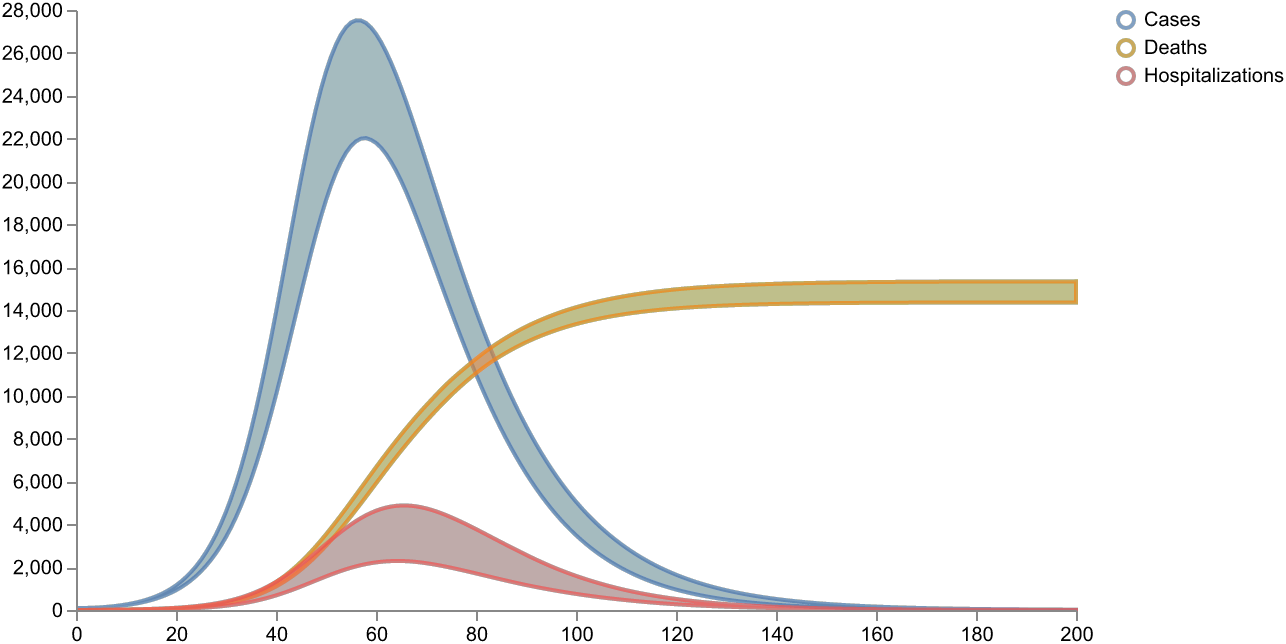

In [60]:
result_sensitivity = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result_sensitivity["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

[19456.83984375 22711.88671875 20560.375      24200.40625
 19067.375      19433.984375   19957.04492188 19310.68945312
 24106.72265625 25417.67382812 22489.0390625  20715.43945312
 19640.54296875 23523.87695312 24640.79882812 19494.46484375
 20793.33203125 20782.90234375 20525.88671875 22071.60546875
 22271.24609375 22863.96679688 21300.98242188 19591.83203125
 19368.95117188 23771.73242188 23846.20703125 25793.83203125
 20396.77734375 19905.95703125 20374.109375   22749.63476562
 23642.87695312 22131.45703125 21959.3984375  23578.99804688
 18953.13476562 22031.15039062 24511.41796875 25853.25390625
 25106.078125   24784.08203125 20181.34960938 20358.29101562
 20165.2109375  20923.0078125  19534.73828125 21814.84375
 23330.21679688 24547.63476562 25069.58398438 19429.43164062
 21325.66015625 22660.32226562 18895.68554688 23661.00585938
 19903.484375   22833.28320312 25562.61132812 21281.84960938
 24922.83203125 22917.1328125  22407.6484375  19207.375
 23293.56054688 25745.046875   2101

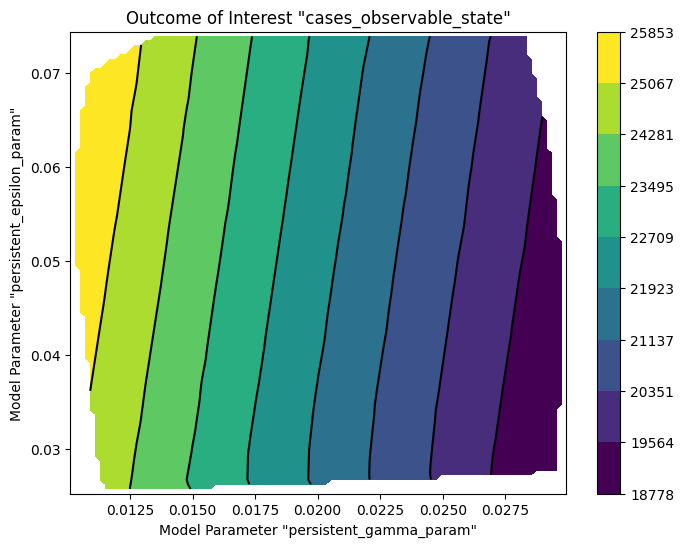

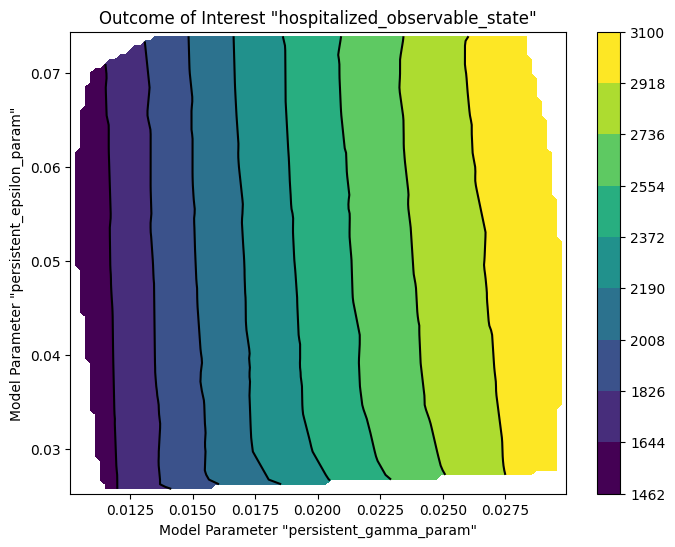

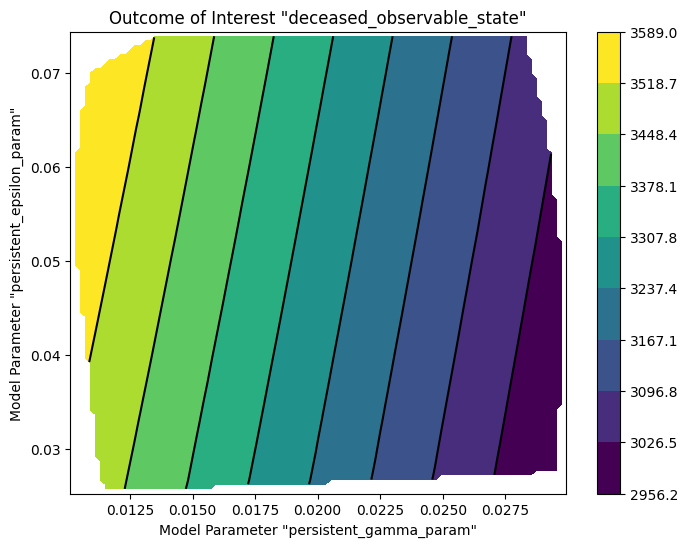

In [61]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

d1 = result_sensitivity["data"]
\
def get_contour_plot(d1, x, column_x, column_y, outcome):

    n = d1["sample_id"].max()
    b = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_x].iloc[0] for i in range(n)])
    rHR = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_y].iloc[0] for i in range(n)])
    outcomes = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][outcome].iloc[0] for i in range(n)])
    print(outcomes)

    xy = np.c_[b, rHR]
    lut2 = LinearNDInterpolator(xy, outcomes)

    # Interpolate to a uniform grid
    m = 100
    x = np.linspace(b.min(), b.max(), m)
    y = np.linspace(rHR.min(), rHR.max(), m)
    xx, yy = np.meshgrid(x, y)

    zz = lut2(xx, yy)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    h1 = ax.contourf(xx, yy, zz, np.linspace(outcomes.min(), outcomes.max(), 10), cmap=plt.cm.viridis.resampled(10 - 1))
    h2 = ax.contour(xx, yy, zz, h1.levels, colors='k')
    __ = fig.colorbar(h1, ax=ax)

    __ = plt.setp(ax, xlabel=f'Model Parameter "{column_x}"', ylabel=f'Model Parameter "{column_y}"', title=f'Outcome of Interest "{outcome}"')

get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "cases_observable_state")
get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "hospitalized_observable_state")
get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "deceased_observable_state")


### 4.2 Decision Maker


In [62]:
# 𝛼 (alpha) r_ID  = 0.01 / 𝑑𝑎𝑦 is the death rate for infected individuals who are not hospitalized
# 𝛽 (beta) r_SE= 0.60 new infections per infected person/day is the transmission rate
# 𝛿 (delta) r_IR= 0.05 / 𝑑𝑎𝑦 is the rate infected individuals recover
# 𝜖 (epsilon) r_VE (I think the diagram in pdf is wrong V goes to E, not I based on the equations)= 0.05 / 𝑑𝑎𝑦 is the rate exposed and vaccinated individuals become infected
# 𝛾 (gamma) r_IH = 0.02 / 𝑑𝑎𝑦 is the rate infected individuals become hospitalized
# 𝜇 (mu) r_HD = 0.02 / 𝑑𝑎𝑦 is the death rate for hospitalized individuals
# 𝜈 (nu) r_SV = 0.005 / 𝑑𝑎𝑦 is the vaccination rate
# 𝜌 (rho) r_HR = 0.10 / 𝑑𝑎𝑦 is the rate hospitalized individuals recover
# 𝜎 (sigma) r_EI = 0.10 / 𝑑𝑎𝑦 is the rate exposed and unvaccinated individuals become infected

In [63]:
model_intervention = "scenerio_3_mo_intervention.json"
start_time = 0.0
end_time = 200.0

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


{'cases_observable_state': 'Cases', 'hospitalized_observable_state': 'Hospitalizations', 'deceased_observable_state': 'Deaths'}


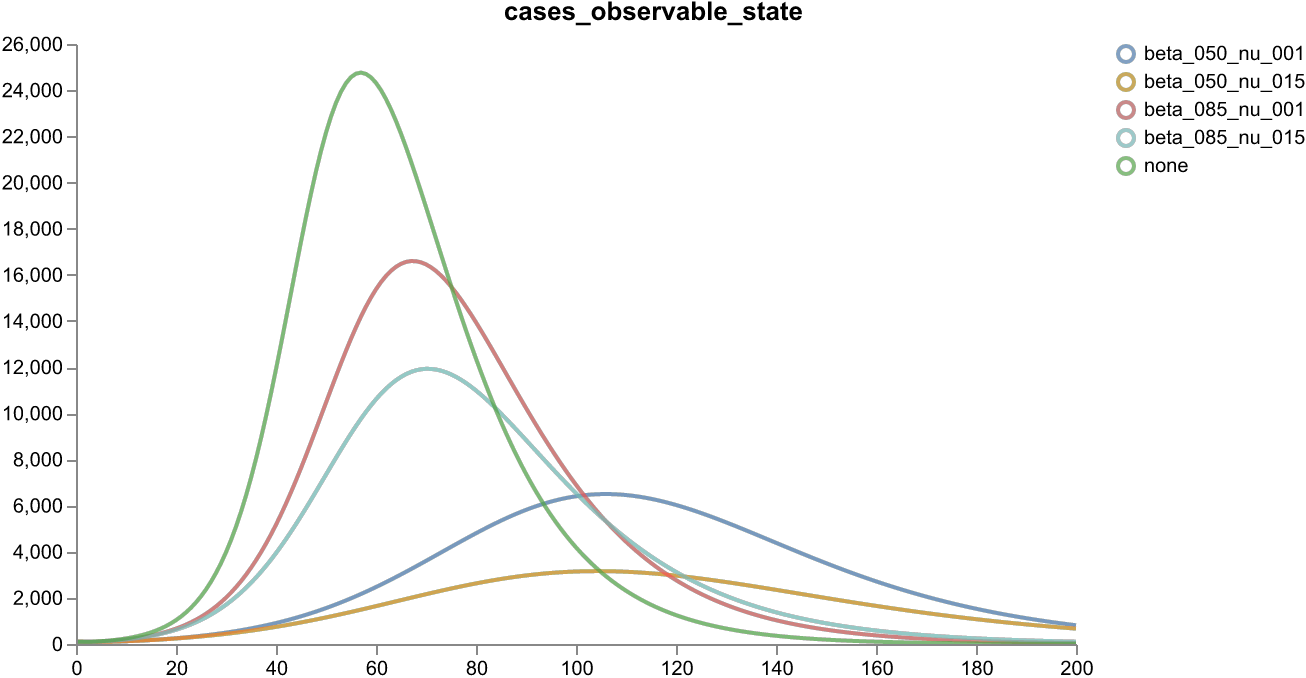

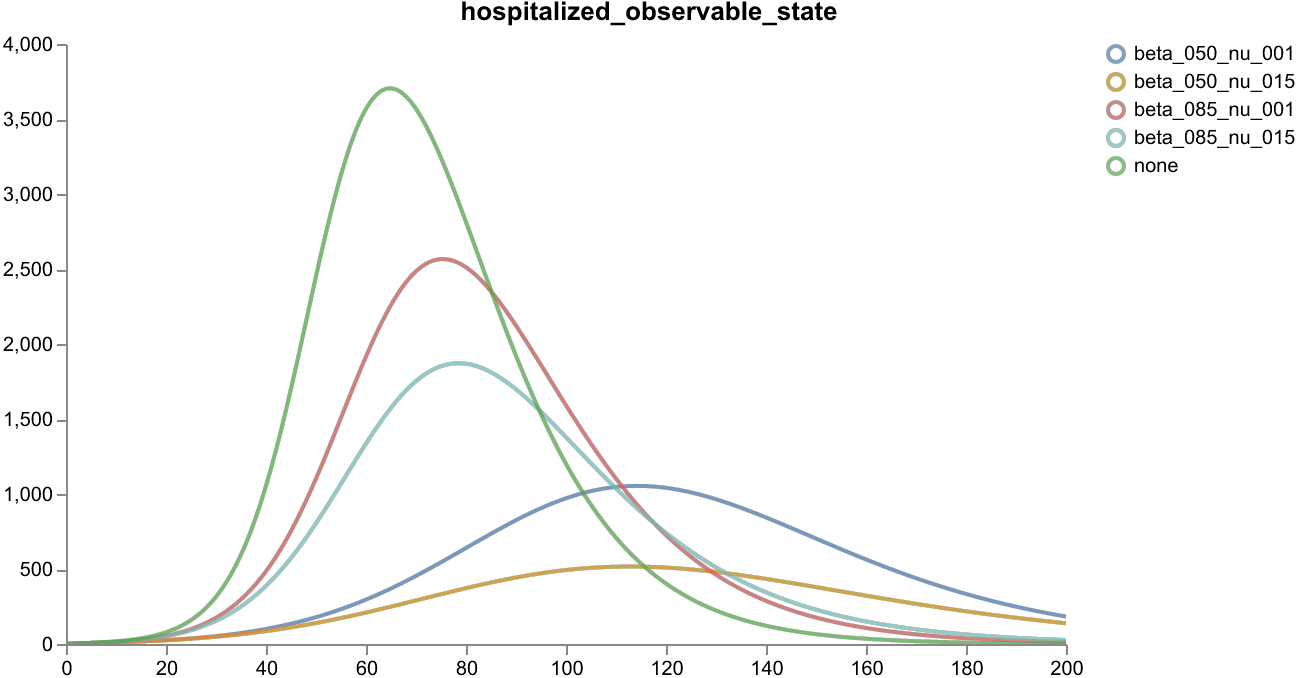

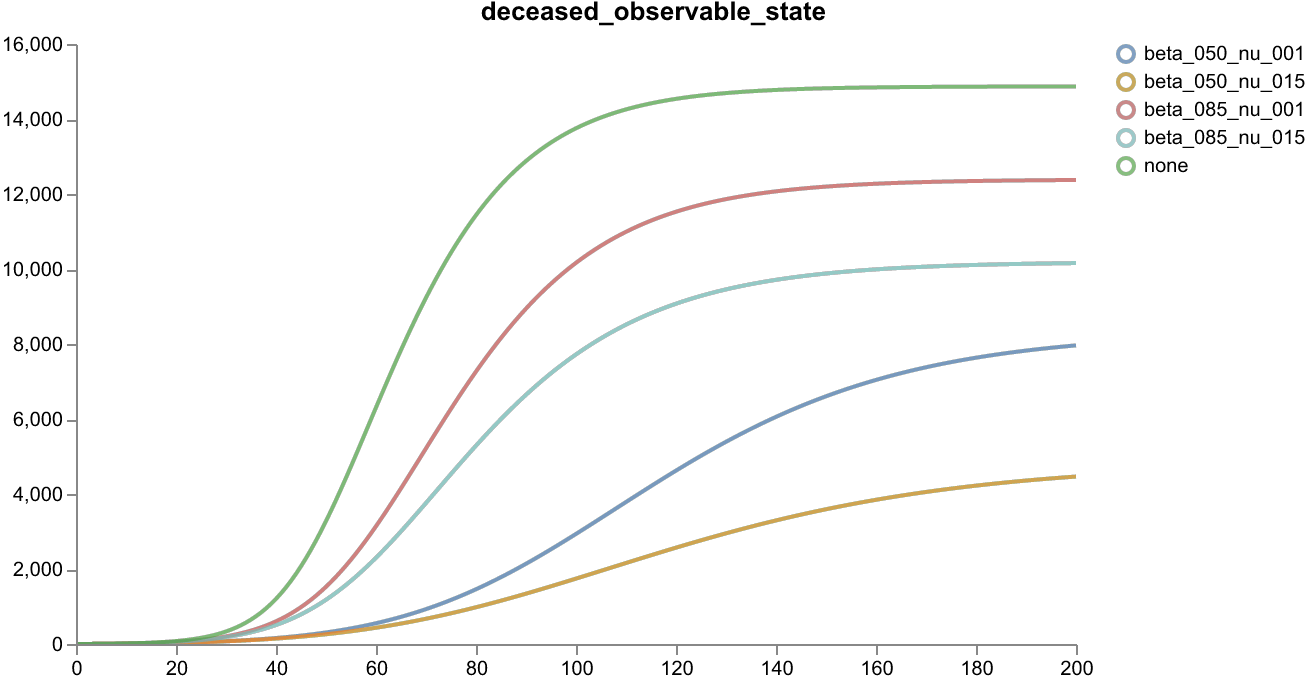

In [64]:
interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
new_labels = nice_labels.copy()
results_dict_dist = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            new_labels[f"{label}_intervention_{key}"] = key
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
    
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results


print(nice_labels)
# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=new_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))


In [65]:
import pandas as pd



# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict_dist.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,7.75,2.77,14867.67
intervention_beta_085_nu_001,47.27,13.84,12373.42
intervention_beta_050_nu_001,812.00,183.18,7962.66
intervention_beta_085_nu_015,101.37,26.64,10158.21
intervention_beta_050_nu_015,666.24,138.57,4464.87


### 4.3 Decision Maker + Uncertainity at 50 days



In [66]:
model_intervention_distribution = "scenerio_3_mo_intervention_uncertainity.json"
start_time = 0.0
end_time = 50.0

seir_model_dist = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention_distribution, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model_dist), fh, indent=1)


{'cases_observable_state': 'Cases', 'hospitalized_observable_state': 'Hospitalizations', 'deceased_observable_state': 'Deaths'}


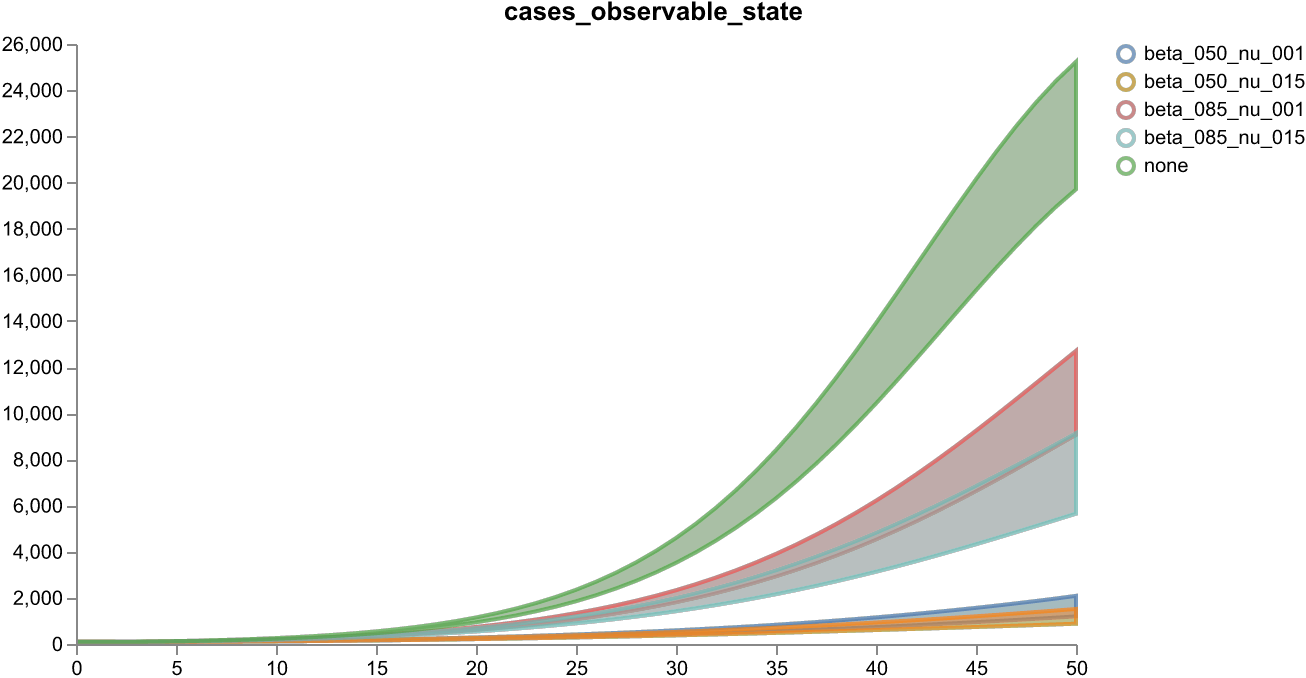

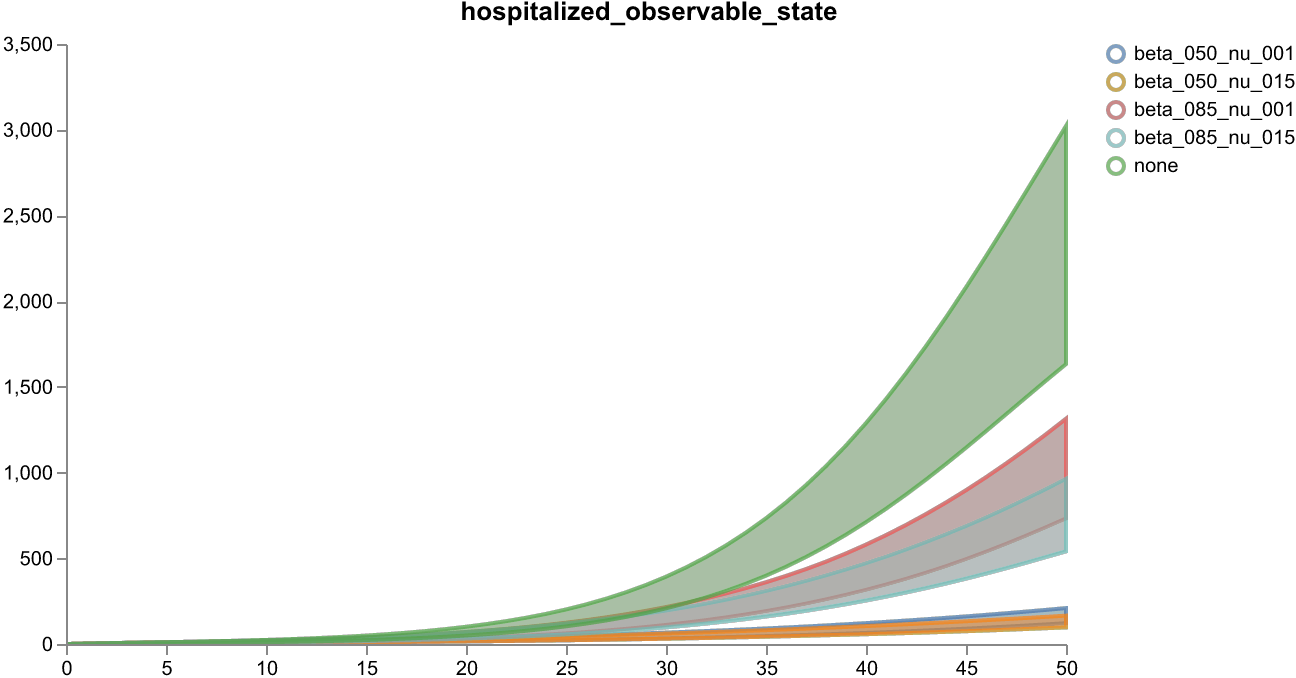

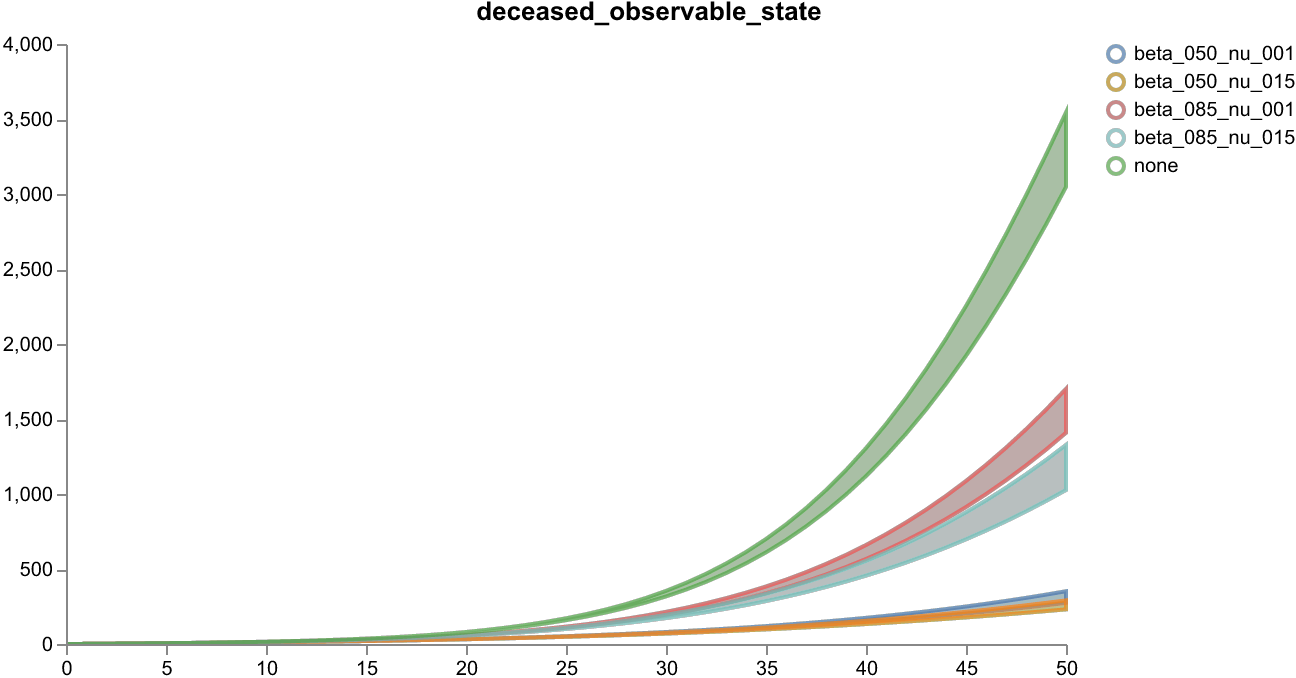

In [67]:

interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
nice_labels = {
    "cases_observable_state": "Cases",
    "hospitalized_observable_state": "Hospitalizations", 
    "deceased_observable_state": "Deaths"
}
new_labels = nice_labels.copy()
results_dict_dist = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention_distribution, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            new_labels[f"{label}_intervention_{key}"] = key
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
    
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 50]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results


print(nice_labels)
# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=new_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))

In [68]:
import pandas as pd


results_dict_dist
# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict_dist.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,22433.60,2356.79,3302.37
intervention_beta_085_nu_001,10687.18,1052.12,1537.65
intervention_beta_050_nu_001,1597.28,178.14,309.73
intervention_beta_085_nu_015,7178.77,799.41,1168.36
intervention_beta_050_nu_015,1118.34,139.04,256.89


### 4.4 Horizon Scanning Maker


In [69]:
scenario_3_total_popp_seid =800000 # US Census Bureau

initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 79900
initial_ccases = 0


In [70]:
c_seid = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'I': Concept(name='I', units=person_units()),  # Infectious
    'D': Concept(name='D', units=person_units()),  # Recovered
    'C_c': Concept(name="C_c", units=person_units())  # Cumulative Cases
}

for concept in c_seid:
    c_seid[concept].name = concept


In [100]:
parameters_seid = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units()),  # Death rate for hospitalized individuals
}
parameters_seid_mu_max = parameters_seid.copy()
parameters_seid_mu_max['mu'] = Parameter(name='mu', value=sympy.Float(.09), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .09,
                                                            'maximum': .11}))

parameters_seid_beta_max = parameters_seid.copy()
parameters_seid_beta_max['beta'] = Parameter(name='beta', value=sympy.Float(.85), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .85,
                                                            'maximum': .9}))

In [101]:

initials_seid = {
    "S": Initial(concept=c_seid["S"], expression=initial_susceptible),
    "E": Initial(concept=c_seid["E"], expression=initial_exposed),
    "I": Initial(concept=c_seid["I"], expression=initial_infected),
    "D": Initial(concept=c_seid["D"], expression=initial_deaths),
    "C_c": Initial(concept=c_seid["C_c"], expression=initial_ccases),
}


In [102]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)




#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=mu*I
)



### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)


# List of all transitions
transitions_seid = [se, ei, id, ccases]



In [103]:
observables_seid = {
    'cases': Observable(name='cases', expression=I),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c)
}

In [104]:
model_seid = "scenerio_3_mo_seid.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_beta_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_beta_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_mu_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_mu_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)
# Save as JSON
with open(model_seid, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

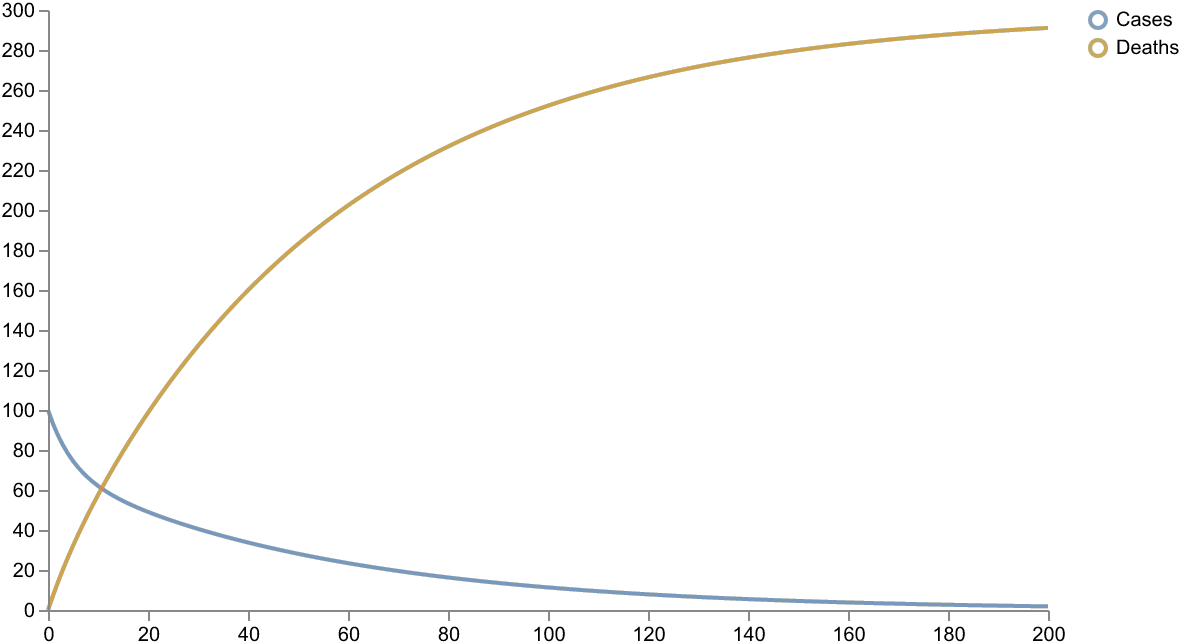

In [105]:
result1 = pyciemss.sample(model_seid, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

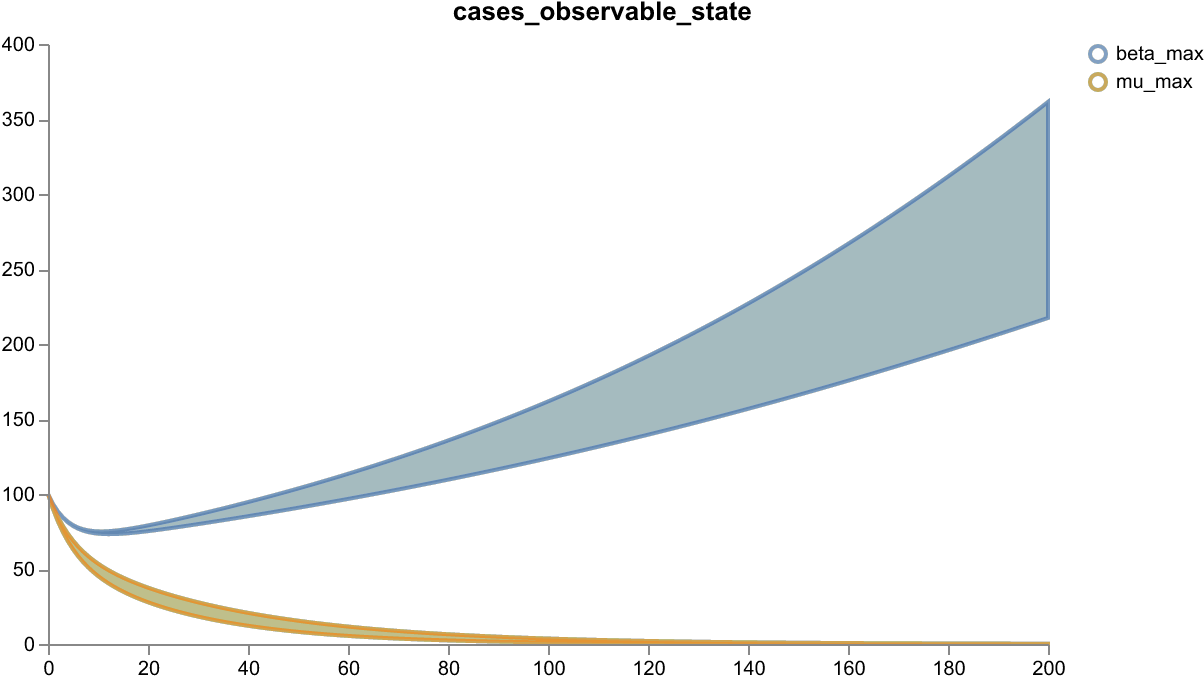

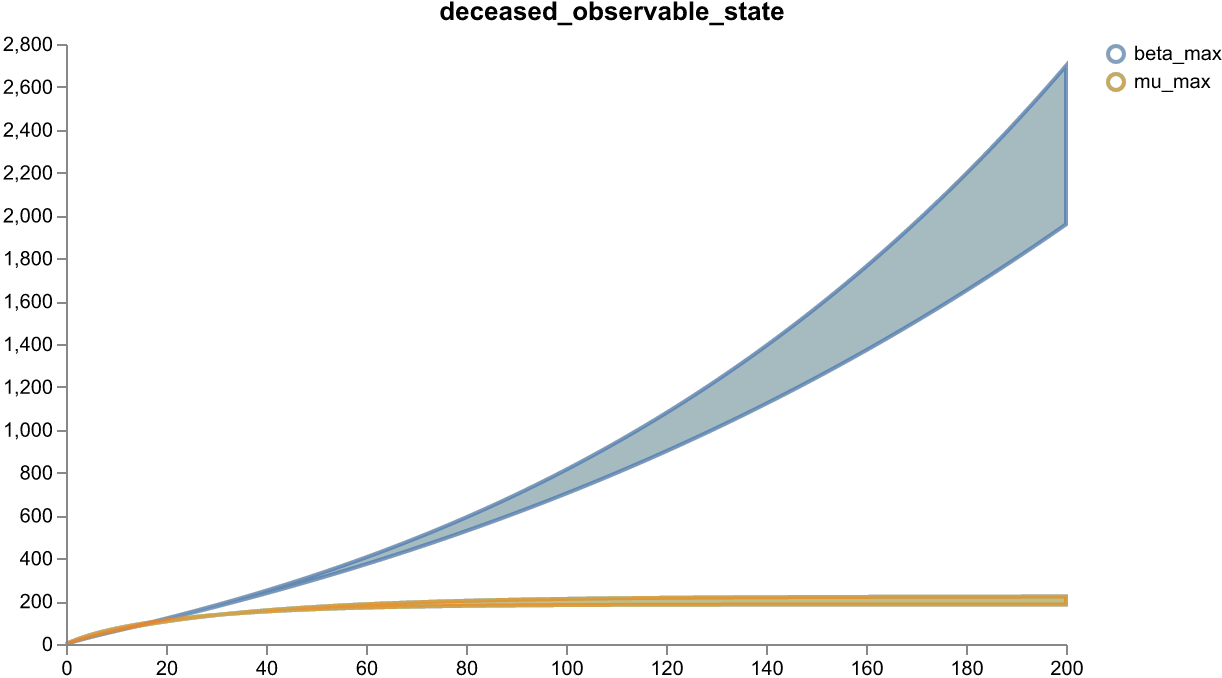

In [106]:
models = {"mu_max": seir_model_mu_max, "beta_max": seir_model_beta_max}
nice_labels = {
    "cases_observable_state": "Cases",
    "deceased_observable_state": "Deaths"
}
labels = nice_labels.copy()
results_dict_horizon = {}

all_results = pd.DataFrame()
for key, model in models.items():
    invervention_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]
            labels[f"{label}_intervention_{key}"] = key
    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_horizon[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))

In [99]:
import pandas as pd


# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict_horizon.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Deaths
intervention_mu_max,0.02,175.36
intervention_beta_max,230.65,2049.96
